# **Superconductivity Regression Notebook**
Trains models to predict critical temperatures based on features found with "*../code/get_featurizers.ipynb*". Imports data from "*../data/supercon_features.csv*", which is produced in *get_featurizers.ipynb*. The orginal data is from the supercon database. This notebook is to produce results in a graphical format, in bulk

*Author: Kirk Kleinsasser*

In [3]:
import dill
#dill.load_session('../data/latest-run.db') #this can load a saved python session so I don't need to rerun computationally expensive cells
%autosave 300 
#autosaves code every five minutes

Autosaving every 300 seconds


In [4]:
#TODO: Do SVR optimization. Redo extratrees optimzation with just n_est. Try RFR more. Try Superlearner more?

#TODO: maybe do comparision of params vs scores
#physics-informed ML 
#lolopy - uncertainty, at least for RFR
#citrine informatics 
#
#start document explaining steps in more detail on optimization choices and such, latex

## Import Libraries / Define Import Data Function

In [1]:
#general imports:
import warnings #to suppress grid search warnings
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #heatmaps
import forestci as fci #error for RFR

#regression models:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet, SGDRegressor, BayesianRidge
from sklearn.svm import SVR
from xgboost import XGBRegressor

#various ML tools:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_predict, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, max_error
from skopt import BayesSearchCV #bayesian optimization

#imports custom libraries (shared functions)
import dependancies.shared_functions as sfn 
from dependancies.superlearner import get_superlearner as superlearner

[MLENS] backend: threading


## Results

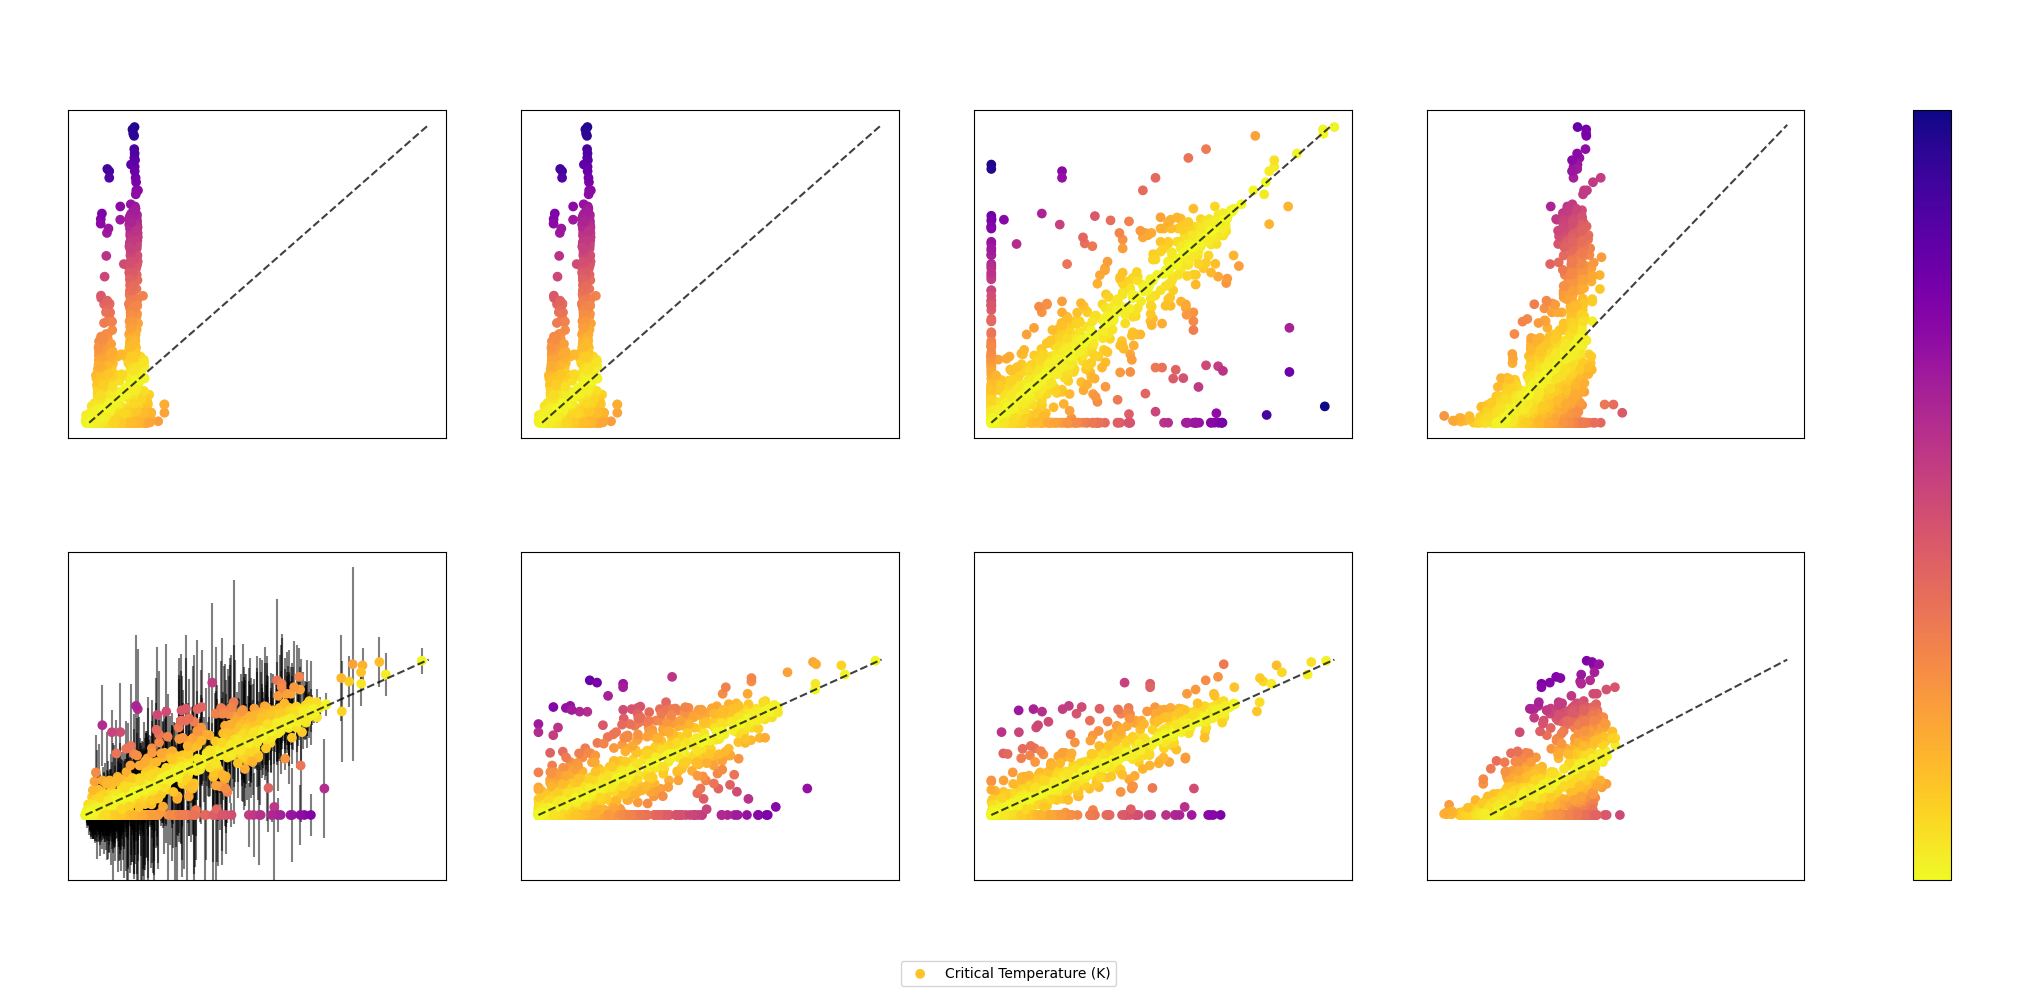

In [3]:
sfn.import_data(replace_inf=True)
models =   [["Support Vector Machines (Linear)", SVR, {}, False, 0, 0],
            ["Random Forest Regression", RandomForestRegressor, {}, True, 1, 0],
            ["Support Vector Machines (Poly)", SVR, {}, False, 0, 1],
            ["KNeighbors Regression", KNeighborsRegressor, {}, False, 1, 1],
            ["Decision Tree Regression", DecisionTreeRegressor, {}, False, 0, 2],
            ["Extra Trees Regression", ExtraTreesRegressor, {}, False, 1, 2],
            ["Elastic Net Regression", ElasticNet, {}, False, 0, 3],
            ["Bayesian Regression", BayesianRidge, {}, False, 1, 3]]
sfn.evaluate(models, title="Prediction vs. Actual Value (CV) - Unoptimized", filename="results_unoptimized.png") #call evaluation function

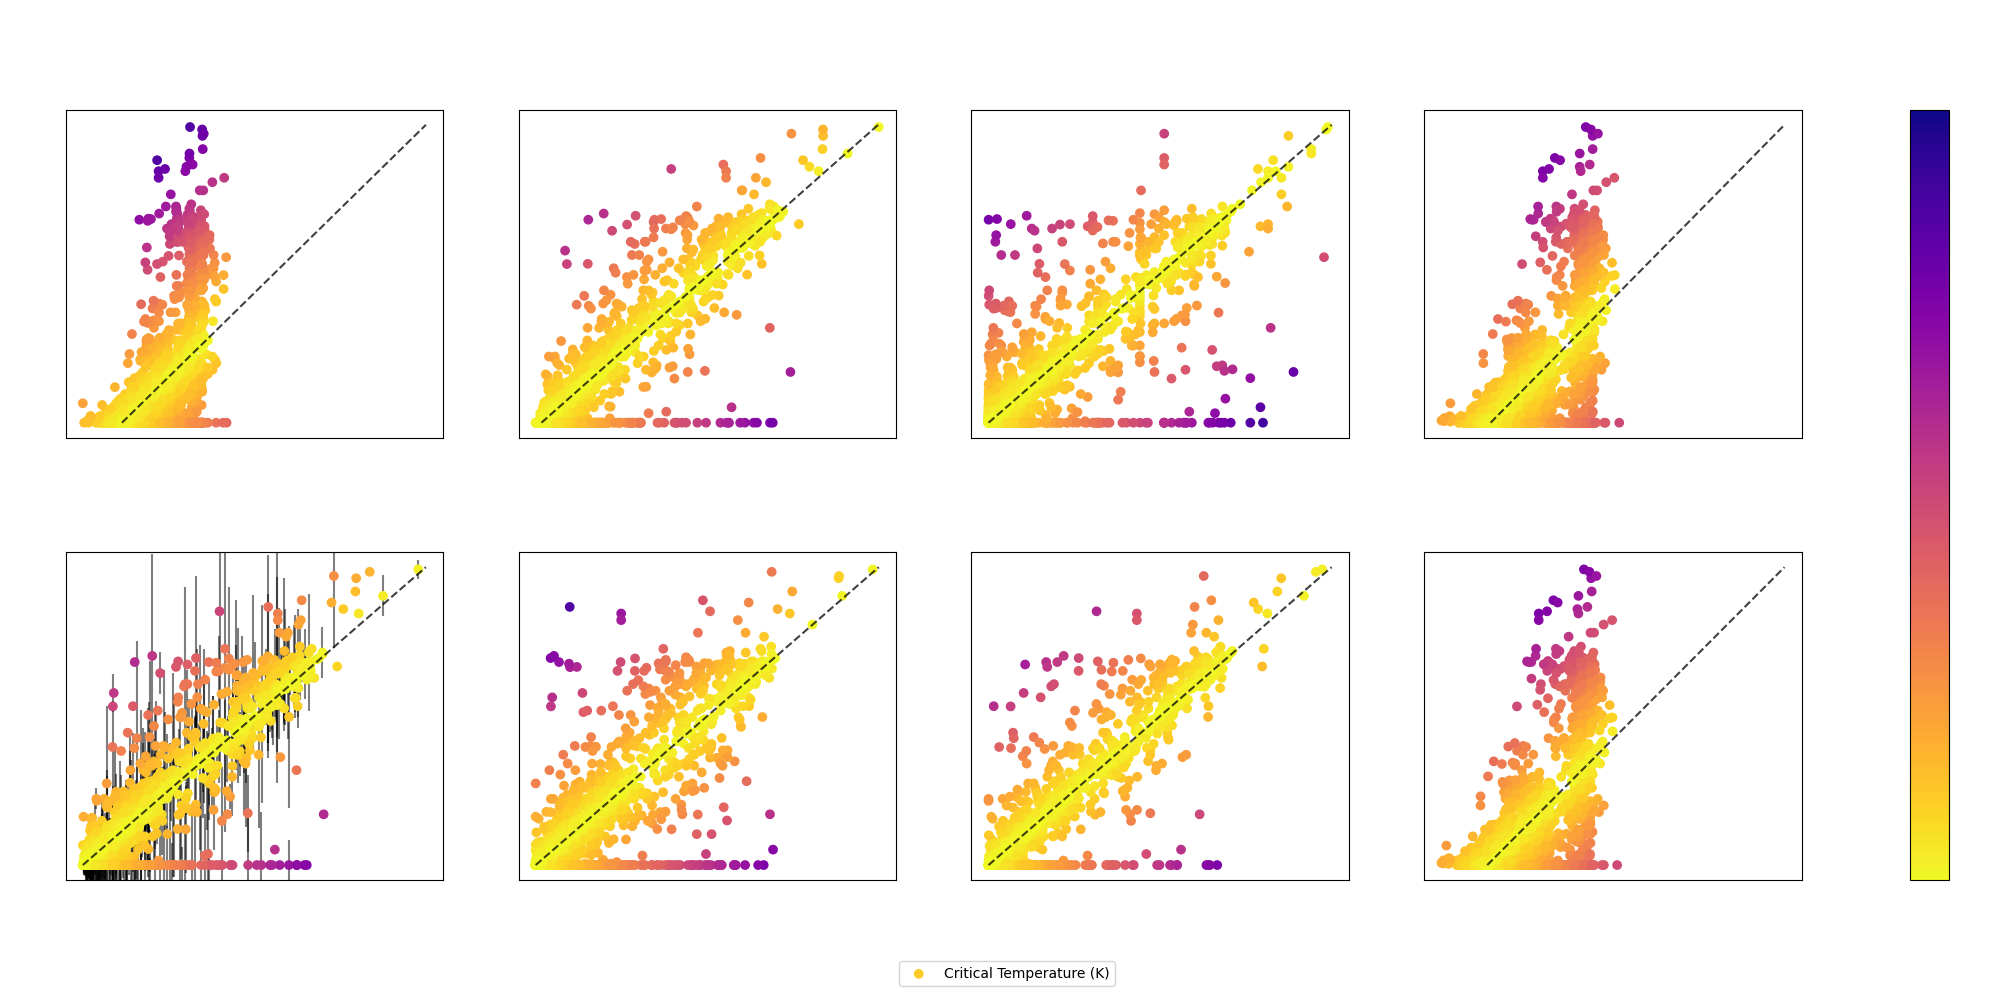

In [4]:
models  =  [["Support Vector Machines", SVR, {'C':1, 'epsilon':10, 'gamma':'auto', 'kernel':'linear'}, False, 0, 0],
            ["Random Forest Regression", RandomForestRegressor, {}, True, 1, 0],
            ["Superlearner", superlearner, {'X': sfn.train_data}, False, 0, 1],
            ["KNeighbors Regression", KNeighborsRegressor, {'metric':'manhattan', 'n_jobs':-1, 'n_neighbors':5}, False, 1, 1],
            ["Decision Tree Regression", DecisionTreeRegressor, {'criterion':'poisson', 'max_features':0.5, 'random_state':43}, False, 0, 2],
            ["Extra Trees Regression", ExtraTreesRegressor, {}, False, 1, 2],
            ["Elastic Net Regression", ElasticNet, {'alpha':1e-05, 'l1_ratio':0.0}, False, 0, 3],
            ["Bayesian Regression", BayesianRidge, {}, False, 1, 3]]
sfn.evaluate(models, title="Prediction vs. Actual Value (CV) - Optimized", filename="results_optimized.png")

In [16]:
# dill.dump_session('../data/supercon_ml_latest_run.db') #this can dump a python session so I can resume later, after restarts and such